<a href="https://colab.research.google.com/github/ella00100/Titanic/blob/main/Titanic_Introduction_to_Ensembling_Stacking01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

- 이 노트북은 앙상블(조합) 학습 모델의 기본 개념을 소개하기 위한 매우 기초적이고 간단한 입문서입니다. 특히 Stacking이라는 앙상블의 변형에 대해 다룹니다. Stacking은 몇 가지 기본 분류기의 예측을 첫 번째 수준(base)으로 사용하고, 이전 첫 번째 수준 예측에서 두 번째 모델을 사용하여 출력을 예측하는 방법입니다.

- 타이타닉 데이터셋은 캐글 초보자들이 시작하기에 이상적인 후보입니다. 또한 앙상블은 캐글 대회에서 여러 팀이 우승하는 데 기여한 것으로 알려져 있지만, 이 주제에 대한 노트북은 많이 부족한 것으로 보입니다. 따라서 이 노트북이 그러한 공백을 어느 정도 채울 수 있기를 바랍니다.

- 저 또한 캐글 씬에 상당히 새로운 입장이며, 제가 우연히 발견하여 공부한 첫 번째 앙상블/스태킹 스크립트는 Faron이 작성한 AllState Severity Claims 대회의 스크립트였습니다. 이 노트북의 자료는 Faron의 스크립트에서 많이 차용했습니다. 단지 분류기의 앙상블로 변형되었을 뿐이며, 그의 스크립트는 회귀 분석기의 앙상블이었습니다.

- 이제 본격적으로 노트북으로 넘어가서 앙상블 개념을 직관적이고 간결한 방식으로 전달할 수 있기를 바랍니다. 이 노트북에서 다루는 앙상블 단계를 정확히 구현한 다른 Kaggle 스크립트는 아래에 제시한 다른 매개 변수를 사용하지만, 동일한 결과를 출력하여 Public LB 점수가 0.808인 상위 9%에 해당합니다. 또한 실행 시간은 4분 이하입니다. 따라서 개선 및 추가할 수 있는 여지가 많다는 것을 확신합니다. 




In [35]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings 
warnings.filterwarnings('ignore')

from sklearn.ensemble import(RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

sns.set(style='white', context='notebook', palette='deep')

# Feature Exploration, Engineering and Cleaning

이제 일반적으로 대부분의 커널 구조와 같이, 우리는 먼저 손에 있는 데이터를 탐색하고 가능한 feature engineering 기회를 식별하며 범주형 특성을 수치적으로 인코딩하는 것으로 진행합니다.

In [36]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle competitions download -c titanic
!ls
!unzip titanic.zip

Saving kaggle.json to kaggle (1).json
titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
 gender_submission.csv	 kaggle.json   test.csv      train.csv
'kaggle (1).json'	 sample_data   titanic.zip
Archive:  titanic.zip
replace gender_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: gender_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [37]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

PassengerId = test["PassengerId"]

train.head(3)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## Feature Engineering

In [38]:
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length']=test['Name'].apply(len)

#객실이 있는지 여부
train['Has_Cabin'] = train['Cabin'].apply(lambda x: 0 if type(x)==float else 1)
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if type(x)==float else 1)

#familysize 카테고리 생성
for dataset in full_data:
  dataset['FamilySize']=dataset['SibSp']+dataset['Parch']+1

#isAlone 카테고리 생성
for dataset in full_data:
  dataset['IsAlone']=0
  dataset.loc[dataset['FamilySize']==1, 'IsAlone']==1

#Embarked의 null 데이터들을 S로 채움
for dataset in full_data:
  dataset['Embarked']=dataset['Embarked'].fillna('S')

#Fare의 null 데이터들을 중앙값으로 채움움
for dataset in full_data:
  dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())

#Fare를 4구간으로 나눔
train['CategoricalFare']=pd.qcut(train['Fare'], 4)

#Age의 null 데이터들을 평균-분산/ 평균+분산 값으로 채움 => 정수로 변경경
for dataset in full_data:
  age_avg = dataset['Age'].mean()
  age_std = dataset['Age'].std()
  age_null_count = dataset['Age'].isnull().sum()
  age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std,
                                           size=age_null_count)
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
  dataset['Age']=dataset['Age'].astype(int)

#Age를 5구간으로 나눔
train['CategoricalAge'] = pd.cut(train['Age'], 5)

#name에서title 추출출
def get_title(name):
  title_search = re.search(' ([A-Za-z]+)\.', name)
  if title_search:
    return title_search.group(1)
  return ""

for dataset in full_data:
  dataset['Title'] = dataset['Name'].apply(get_title)

#Title 값 범위 줄이기
for dataset in full_data:
  dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
  dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Ms', "Miss")
  dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

#숫자형 데이터로 변경
for dataset in full_data:
  dataset['Sex'] = dataset['Sex'].map({'female':0, 'male':1}).astype(int) 
  title_mapping = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Rare':5} 
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)
  dataset['Embarked'] = dataset['Embarked'].map({'S':0, 'C':1, 'Q':2}).astype(int)

  dataset.loc[dataset['Fare'] <= 7.91, 'Fare']=0
  dataset.loc[(dataset['Fare'] > 7.91)&(dataset['Fare']<= 14.454), 'Fare']=1
  dataset.loc[(dataset['Fare'] > 14.454) &(dataset['Fare']<=31),'Fare']=2
  dataset.loc[dataset['Fare'] > 31, 'Fare']=3
  dataset['Fare'] = dataset['Fare'].astype(int)

  dataset.loc[dataset['Age'] <=16, 'Age'] = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] =1
  dataset.loc[(dataset['Age'] >32) & (dataset['Age']<=48), 'Age'] = 2
  dataset.loc[(dataset['Age'] >48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[dataset['Age']>64, 'Age']=4;



In [39]:
#필요없는 데이터 버리기
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train =train.drop(drop_elements, axis=1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis=1)
test = test.drop(drop_elements, axis =1)

- 이제 특징들을 정리하고 필요한 정보를 추출하고 범주형 열을 삭제하여 특징들이 모두 수치형으로 변환되어 머신러닝 모델에 입력할 수 있는 형식이 되었습니다. 

- 그러나 진행하기 전에 우리는 변환된 데이터셋의 간단한 상관 관계 및 분포 그래프를 생성하여 어떻게 생겼는지 확인해보고자 합니다.

# Visualisations

In [40]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,0,2


## Pearson Correlation Heatmap

각 피처 간의 상관관계를 파악하기 위해 피어슨 상관관계 히트맵을 생성해보겠습니다. Seaborn 패키지를 사용하여 간편하게 히트맵을 시각화할 수 있습니다. 

<Axes: title={'center': 'Pearson Correlastion of Reatures'}>

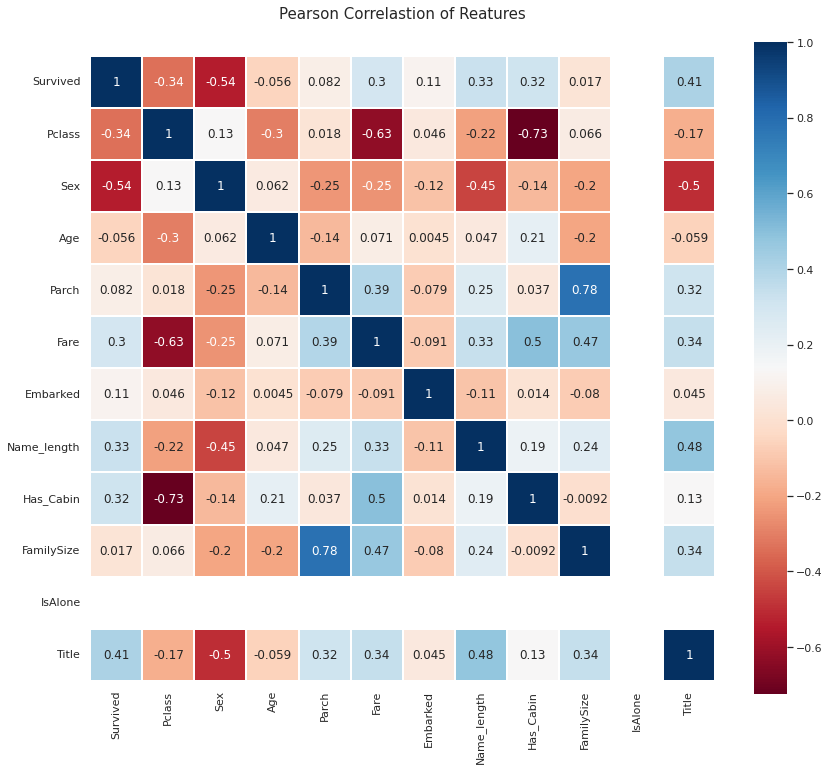

In [41]:
#heatmap에서 사용할 색상 맵 정의
colormap = plt.cm.RdBu

plt.figure(figsize=(14,12))
plt.title('Pearson Correlastion of Reatures', y=1.05, size=15)

#train데이터의 feature간 상관관계 분석
sns.heatmap(train.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

##Takeaway from the Plots
-  Pearson 상관 관계 플롯이 다른 특징과 강하게 상관되어 있지 않습니다. 이것은 학습 모델에 이러한 기능을 전달하는 관점에서 좋은 것입니다. 

- 이는 우리의 훈련 세트에 중복되거나 불필요한 데이터가 많지 않기 때문에 각 특징이 일부 고유한 정보를 지니고 있다는 것을 의미합니다. 

- 가족 규모와 Parch(부모 및 자녀)가 가장 상관 관계가 있는 두 가지 특징입니다. 이 연습의 목적을 위해 두 특징 모두 유지합니다.

## Pairplots
마지막으로 한 특징에서 다른 특징으로 데이터의 분포를 관찰하기 위해 pairplot을 생성합니다. 




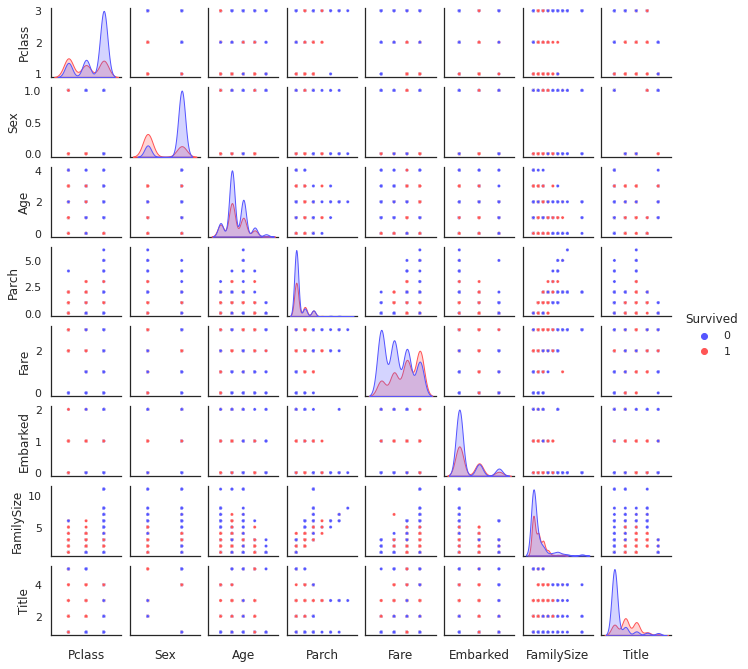

In [42]:
#Pairplots(산점도 매트릭스): 변수 간 scatter plot 생성
#diag_kind = 'kde' : 대각선에 그려질 히스토그램 종류
#diag_kws : 대각선에 그려질 히스토그램 특성
g = sns.pairplot(train[[u'Survived',u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
                        u'FamilySize', u'Title']], hue='Survived', palette='seismic', 
                 size=1.2, diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
g.set(xticklabels=[])

#Ensembling & Stacking models

아래 코드 섹션에서는 SklearnHelper 클래스를 작성하여 모든 Sklearn 분류기에 공통적으로 존재하는 train, predict 및 fit과 같은 내장 메서드를 확장할 수 있도록 합니다. 따라서 다섯 가지 다른 분류기를 호출하려면 동일한 메서드를 다섯 번 쓸 필요가 없으므로 중복을 제거합니다.

In [43]:
#shape[0]는 열차 배열의 행 수(즉, 샘플 수)
ntrain = train.shape[0]
ntest = test.shape[0]
SEED =0
NFOLDS = 5
kf = KFold(n_splits= NFOLDS, shuffle=True, random_state=SEED)

class SklearnHelper(object):
  #클래스 인스턴스를 초기화하고 분류자의 임의 시드를 설정
  def __init__(self, clf, seed=0, params=None): #clf: Scikit-learn분류기, seed: 난수
    params['random_state']=seed 
    self.clf = clf(**params)

  #주어진 피쳐 세트 x_train 및 레이블 y_train에서 clf를 훈련
  def train(self, x_train, y_train): 
    self.clf.fit(x_train, y_train)
  
  #피쳐 세트 x를 사용, 예측 레이블을 반환
  def predict(selt, x):
    return self.clf.predict(x)
  
  def fit(self, x, y):
    return self.clf.fit(x,y)
  
  #분류기에 대한 기능 중요도(사용 가능한 경우)를 출력
  def feature_importances(self,x,y):
    print(self.clf.fit(x,y).feature_importances_)

- 기본 분류자를 만들 때는 이미 Sklearn 라이브러리에 있는 모델만 사용하므로 클래스만 확장합니다.

- definit : 클래스의 기본 생성자를 호출하기 위한 Python 표준입니다. 즉, 개체(분류기)를 생성하려면 clf(원하는 sklearn 분류기), 시드(랜덤 시드) 및 매개 변수(분류기용 매개 변수)의 매개 변수를 지정해야 합니다.

- 나머지 코드는 단순히 클래스의 메서드로, sklearn 분류기 내에 이미 존재하는 해당 메서드를 호출합니다. 기본적으로 다양한 Sklearn 분류기를 확장하기 위해 래퍼 클래스를 만들어 여러 학습자를 Stacker에 구현할 때 동일한 코드를 반복해서 작성해야 하는 것을 줄일 수 있습니다.


## Out-of-Fold Predictions
- 이제 위의 소개 섹션에서 언급한 바와 같이, Stacking은 기본 분류자의 예측을 2단계 모델에 대한 교육을 위한 입력으로 사용합니다. 

- 그러나 단순히 전체 훈련 데이터에 대한 기본 모델을 훈련하고 전체 테스트 세트에 대한 예측을 생성한 다음 2차 훈련에 대해 이를 출력할 수는 없습니다. 

- 따라서 기본 모형 예측이 이미 검정 세트를 "확인"했으므로 이러한 예측을 제공할 때 과적합될 위험이 있습니다.

In [44]:
def get_oof(clf, x_train, y_train, x_test):
  '''
  각각의 분류기(classifier)의 Out-of-Fold(oof) 예측을 생성하는 함수
  '''
  oof_train = np.zeros((ntrain))
  oof_test = np.zeros((ntest))
  oof_test_skf = np.empty((NFOLDS, ntest))

  for i, (train_index, test_index) in enumerate(kf.split(x_train)):
      x_tr = x_train[train_index]
      y_tr = y_train[train_index]
      x_te = x_train[test_index]

      clf.fit(x_tr, y_tr)

      oof_train[test_index] = clf.predict(x_te)
      oof_test_skf[i, :] = clf.predict(x_test)

  oof_test[:] = oof_test_skf.mean(axis=0)
  return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


## Generating our Base First-Level Models
- 이제 첫 번째 레벨 분류로 다섯 가지 학습 모델을 준비하겠습니다. 이러한 모델은 모두 Sklearn 라이브러리를 통해 편리하게 호출할 수 있으며 다음과 같이 나열되어 있습니다
  - Random Forest classifier
  - Extra Trees classifier
  - AdaBoost classifer
  - Gradient Boosting classifer
  - Support Vector Machine

- 완전성을 위해 여기에 나열할 매개변수에 대한 간단한 요약 입니다.
  - n_jobs : 교육 과정에 사용된 코어 수입니다. -1로 설정하면 모든 코어가 사용됩니다.
  - n_estimators : 학습 모델의 분류 트리 수(기본값당 10개로 설정)
  - max_depth : 트리의 최대 깊이 또는 노드를 확장해야 하는 양입니다. 너무 높은 수치로 설정하면 나무가 너무 깊게 자랄 수 있으므로 과적합의 위험이 있습니다
  - verbose : 학습 프로세스 중에 텍스트를 출력할지 여부를 제어합니다. 값이 0이면 모든 텍스트가 표시되지 않으며 값이 3이면 반복할 때마다 트리 학습 프로세스가 출력됩니다.





In [45]:
rf_params={
    'n_jobs':-1,
    'n_estimators' : 500,
    'warm_start' : True,
    'max_depth' : 6,
    'min_samples_leaf' : 2,
    'max_features' : 'sqrt',
    'verbose' :0
}

et_params={
    'n_jobs':-1,
    'n_estimators' : 500,
    'max_depth' : 8,
    'min_samples_leaf' : 2,
    'verbose' :0
}

ada_params={
    'n_estimators' : 500,
    'learning_rate' :0.75
}

gb_params={
    'n_estimators' : 500,
    'max_depth' : 5,
    'min_samples_leaf' : 2,
    'verbose' :0
}

svc_params={
    'kernel' : 'linear',
    'C' : 0.025
}

- OOP 프레임워크 내의 객체 및 클래스에 대해 언급했으므로 이제 앞에서 정의한 Helper Sklearn Class를 통해 5개의 학습 모델을 나타내는 5개의 객체를 생성하겠습니다.

In [46]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

## Creating NumPy arrays out of our train and test sets
첫 번째 계층 기본 모델을 준비했으므로 이제 다음과 같이 원래 데이터 프레임에서 NumPy 어레이를 생성하여 분류기에 입력할 교육 및 테스트 데이터를 준비할 수 있습니다.


In [47]:
train.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked',
       'Name_length', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title'],
      dtype='object')

In [48]:
y_train = train['Survived'].ravel() #평평하게 배열
train = train.drop(['Survived'], axis=1)
x_train = train.values
x_test = test.values

## Output of the First level Predictions

이제 교육 및 테스트 데이터를 5개의 기본 분류기에 제공하고 이전에 정의한 Out-of-Fold 예측 기능을 사용하여 첫 번째 수준 예측을 생성합니다. 아래 코드 청크가 실행될 때까지 몇 분 정도 기다립니다.

In [50]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf, x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb, x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc, x_train, y_train, x_test)

print('Training is complete')


NameError: ignored

## Feature importances generated from the different classifiers

- 제 1단계 분류기를 학습한 후, 우리는 Sklearn 모델의 매우 정교한 기능을 활용할 수 있습니다. 즉, 교육 및 테스트 세트에서 다양한 기능의 중요성을 매우 간단한 코드 한 줄로 출력하는 것입니다.

- Sklearn 설명서에 따르면 대부분의 분류자는 .featureimports를 입력하기만 하면 기능 중요도를 반환하는 속성과 함께 기본 제공됩니다. 따라서 함수를 통해 이 매우 유용한 속성을 호출하고 기능의 중요성을 플롯합니다


In [51]:
rf_feature = rf.feature_importances(x_train, y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train, y_train)

[0.11258167 0.241093   0.03336225 0.02123707 0.05245438 0.0232288
 0.11183657 0.06367698 0.07360352 0.         0.26692577]
[0.13008176 0.39001682 0.02726578 0.01958061 0.05687052 0.028588
 0.04492882 0.08231304 0.0493695  0.         0.17098516]
[0.032 0.012 0.018 0.064 0.034 0.01  0.688 0.012 0.058 0.    0.072]
[0.08567932 0.01009271 0.05738501 0.01231677 0.04845776 0.02226912
 0.1730318  0.03819685 0.11720489 0.         0.43536577]


- 기능 중요도를 직접 할당하고 저장하는 방법을 아직 파악하지 못했습니다. 

- 따라서 위의 코드에서 값을 출력한 다음 아래와 같이 Python 목록에 복사하여 붙여넣을 것입니다

In [52]:
rf_features = [0.10474135,  0.21837029,  0.04432652,  0.02249159,  0.05432591,  0.02854371
  ,0.07570305,  0.01088129 , 0.24247496,  0.13685733 , 0.06128402]
et_features = [ 0.12165657,  0.37098307  ,0.03129623 , 0.01591611 , 0.05525811 , 0.028157
  ,0.04589793 , 0.02030357 , 0.17289562 , 0.04853517,  0.08910063]
ada_features = [0.028 ,   0.008  ,      0.012   ,     0.05866667,   0.032 ,       0.008
  ,0.04666667 ,  0.     ,      0.05733333,   0.73866667,   0.01066667]
gb_features = [ 0.06796144 , 0.03889349 , 0.07237845 , 0.02628645 , 0.11194395,  0.04778854
  ,0.05965792 , 0.02774745,  0.07462718,  0.4593142 ,  0.01340093]

- Plotly 패키지를 통해 쉽게 표시할 수 있도록 형상 중요도 데이터가 포함된 목록에서 데이터 프레임을 만듭니다.

In [53]:
cols = train.columns.values

feature_dataframe = pd.DataFrame({'features' : cols,
                                  'Random Forest feature importances' : rf_features,
                                  'Extra Trees feature importances' : et_features,
                                  'AdaBoost feature importances' : ada_features,
                                  'Gradient Boost feature importances' : gb_feature})

## Interactive feature importances via Plotly scatterplots

이 시점에서 대화형 Plotly 패키지를 사용하여 다음과 같이 "산포"를 호출하여 플롯 산란 플롯을 통해 여러 분류자의 피쳐 중요도 값을 시각화합니다

In [54]:
trace = go.Scatter(
    y=feature_dataframe['Random Forest feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref=1,
        size=25,
        color = featuer_dataframe['Random Forest feature importances'].values,
        colorscale = 'Portland',
        showscale=True),
    text = feature_dataframe['features'].values
)

data = [trace]

layout = go.Layout(
    autosize=True,
    title='Random Forest Feature Importance',
    hovermode='closest'
    yaxis=dict(title='Feature Importance',ticklen=5,gridwidth=2),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

trace = go.Scatter(
    y=feature_dataframe['Extra Trees feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref=1,
        size=25,
        color=feature_datafram['Extra Trees feature importances'].values,
        colorscale ='Portland'
        showscale=True),
    text=feature_dataframe['features'].values
)

data=[trace]

layout = go.Layout(
    autosize=True,
    title='Extra Trees Feature Importance',
    hovermode='closest',
    yaxis=dict(
        title = 'Feature Importance',
        ticklen=5,
        gridwidth=2),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='scatter2010')

trace = go.Scatter(
    y=feature_dataframe['AdaBoost feature importances'].values,
    x=feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale = 'Portland',
        showscale=True),
    text = feature_dataframe['features'].values
)
data =[trace]

layout = go.Layout(
    autosize=True,
    title='AdaBoost Feature Importance',
    hovermod ='closest',
    yaxis=dict(
        title='Feature Importance',
        ticklen=5,
        gridwidth=2),
    showlegend=False
)
fig = go.Figure(data=data, layout=layout)
py,iplot(fig, filename='scatter2010')

trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


SyntaxError: ignored

- 이제 모든 형상 중요도의 평균을 계산하여 형상 중요도 데이터 프레임에 새 열로 저장하겠습니다.

In [61]:
feature_dataframe['mean'] = feature_dataframe.mean(axis=1)
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,Pclass,0.104741,0.121657,0.028,None,0.084799
1,Sex,0.218370,0.370983,0.008,None,0.199118
2,Age,0.044327,0.031296,0.012,None,0.029208


## Plotly Barplot of Average Feature Importances

모든 분류기에서 평균 피쳐 중요도를 구하면 다음과 같이 플롯리 막대 그래프로 그릴 수 있습니다. 

In [64]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
    x=x, y=y, width = 0.5, marker=dict(
        color = feature_dataframe['mean'].values,
        colorscale='Portland',
        showscale=True,
        reversescale=False),opacity=0.6)]

layout = go.Layout(autosize=True, title = 'Barplots of Mean Feature Importance',
    hobermode='closest',yaxis=dict(title='Feature Importance',ticklen=5, gridwidth=2),
    showlegend=False
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='bar-direct-labels')

ValueError: ignored

# Second-Level Predictions from the First-level Output

## First-level output as new features
이제 우리의 첫 번째 수준 예측을 얻었기 때문에, 그것은 본질적으로 다음 분류기의 훈련 데이터로 사용될 새로운 기능 세트를 구축하는 것이라고 생각할 수 있습니다. 따라서 아래 코드에 따라 이전 분류기의 1단계 예측을 새 열로 지정하고 이에 대한 다음 분류기를 교육합니다.


In [59]:
base_predictions_train =pd.DataFrame({'RandomForest':rf_oof_train.ravel(),
                                      'ExtraTrees':et_oof_train.ravel(),
                                      'AdaBoost':ada_oof_train.ravel(),
                                      'GradientBoost':gb_oof_train.ravel()})
base_predictions_train.head()

NameError: ignored

## Correlation Heatmap of the Second Level Training set

In [60]:
data = [go.Heatmap(z=base_predictions_train.columns.values,
                   x=base_predictions_train.columns.values,
                   y=base_predictions_train.columns.values,
                   colorscale='Viridis',
                   showscale=True,
                   reversescale=True)]
        
py.iplot(data,filename='labeled-heatmap')

NameError: ignored

In [ ]:
x_train = np.concatenate((et_oof_train, rf_oof_rain, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate((et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, sbc_oof_test), axis=1)


- 이제 x_train과 x_test로 1단계 열차와 테스트 예측을 연결하고 결합하여 2단계 학습 모델을 맞출 수 있습니다.

## Second level learning model via XGBoost

- 여기서는 강화된 트리 학습 모델인 XGBoost로 매우 유명한 eXt 라이브러리를 선택합니다. 그것은 대규모 증가 트리 알고리즘을 최적화하기 위해 만들어졌습니다. 

- 어쨌든, 우리는 XGB 분류기를 호출하여 1단계 열차 및 대상 데이터에 맞추고 학습된 모델을 사용하여 다음과 같이 테스트 데이터를 예측합니다

In [57]:
gbm = xgb.XGBClassifier(n_estimators=2000,
                        max_depth=4, min_child_weight=2,
                        gamma=0.9, subsample=0.8,
                        colsample_bytree=0.8, objective='binary:logistic',
                        nthread=-1, scale_pos_weight=1).fit(x_train, y_train)

predictions=gbm.predict(x_test)

- max_depth : 트리를 얼마나 깊게 성장시킬 것인지를 나타냅니다. 숫자를 너무 높게 설정하면 과적합의 위험이 발생할 수 있으므로 주의하십시오.

- gamma : 트리의 리프 노드에 추가 파티션을 만드는 데 필요한 최소 손실 감소. 크기가 클수록 알고리즘이 더 보수적입니다.

- eta : 과적합 방지를 위해 각 부스팅 단계에서 사용되는 스텝 크기 수축

## Producing the Submission file
마침내 우리의 모든 1단계 및 2단계 모델을 교육하고 적합하게 만들었기 때문에, 우리는 이제 다음과 같이 타이타닉 대회에 제출할 수 있는 적절한 형식으로 예측을 출력할 수 있습니다

In [58]:
StackingSubmission = pd.DataFrame({'PassengerId':PassengerId, 'Survived':predictions})

StackingSubmission.to_csv("StackingSubmission.csv", index=False)


##Steps for Further Improvement
- 마지막으로 위에서 수행한 단계는 앙상블 스태커를 생성하는 매우 간단한 방법을 보여줍니다. 당신은 2레벨 이상의 스택 레벨뿐만 아니라 스택 분류기의 놀라운 조합을 포함하는 카글 대회의 최고 레벨에서 만들어진 앙상블에 대해 듣습니다.

- 점수를 향상시키기 위해 취할 수 있는 몇 가지 추가 조치는 다음과 같습니다:

- 최적의 매개 변수 값을 찾기 위해 모델을 교육하는 데 우수한 교차 검증 전략 구현
학습을 위한 더 다양한 기본 모델을 소개합니다. 상관 관계가 없는 결과일수록 최종 점수가 높습니다.